<a href="https://colab.research.google.com/github/puddingoverdose/SABER-HEMA-Hit-Detection/blob/main/SABER_HEMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install roboflow opencv-python matplotlib shapely

In [ ]:
from roboflow import Roboflow
import cv2
from google.colab.patches import cv2_imshow  # Colab-specific function to display images
from shapely.geometry import box, LineString


In [ ]:
rf = Roboflow(api_key="AAWAWVrKT7vTR4s80aCu")
project = rf.workspace().project("saber-hema-hit-detection")  # Replace with your project name
model = project.version(1).model

loading Roboflow workspace...
loading Roboflow project...


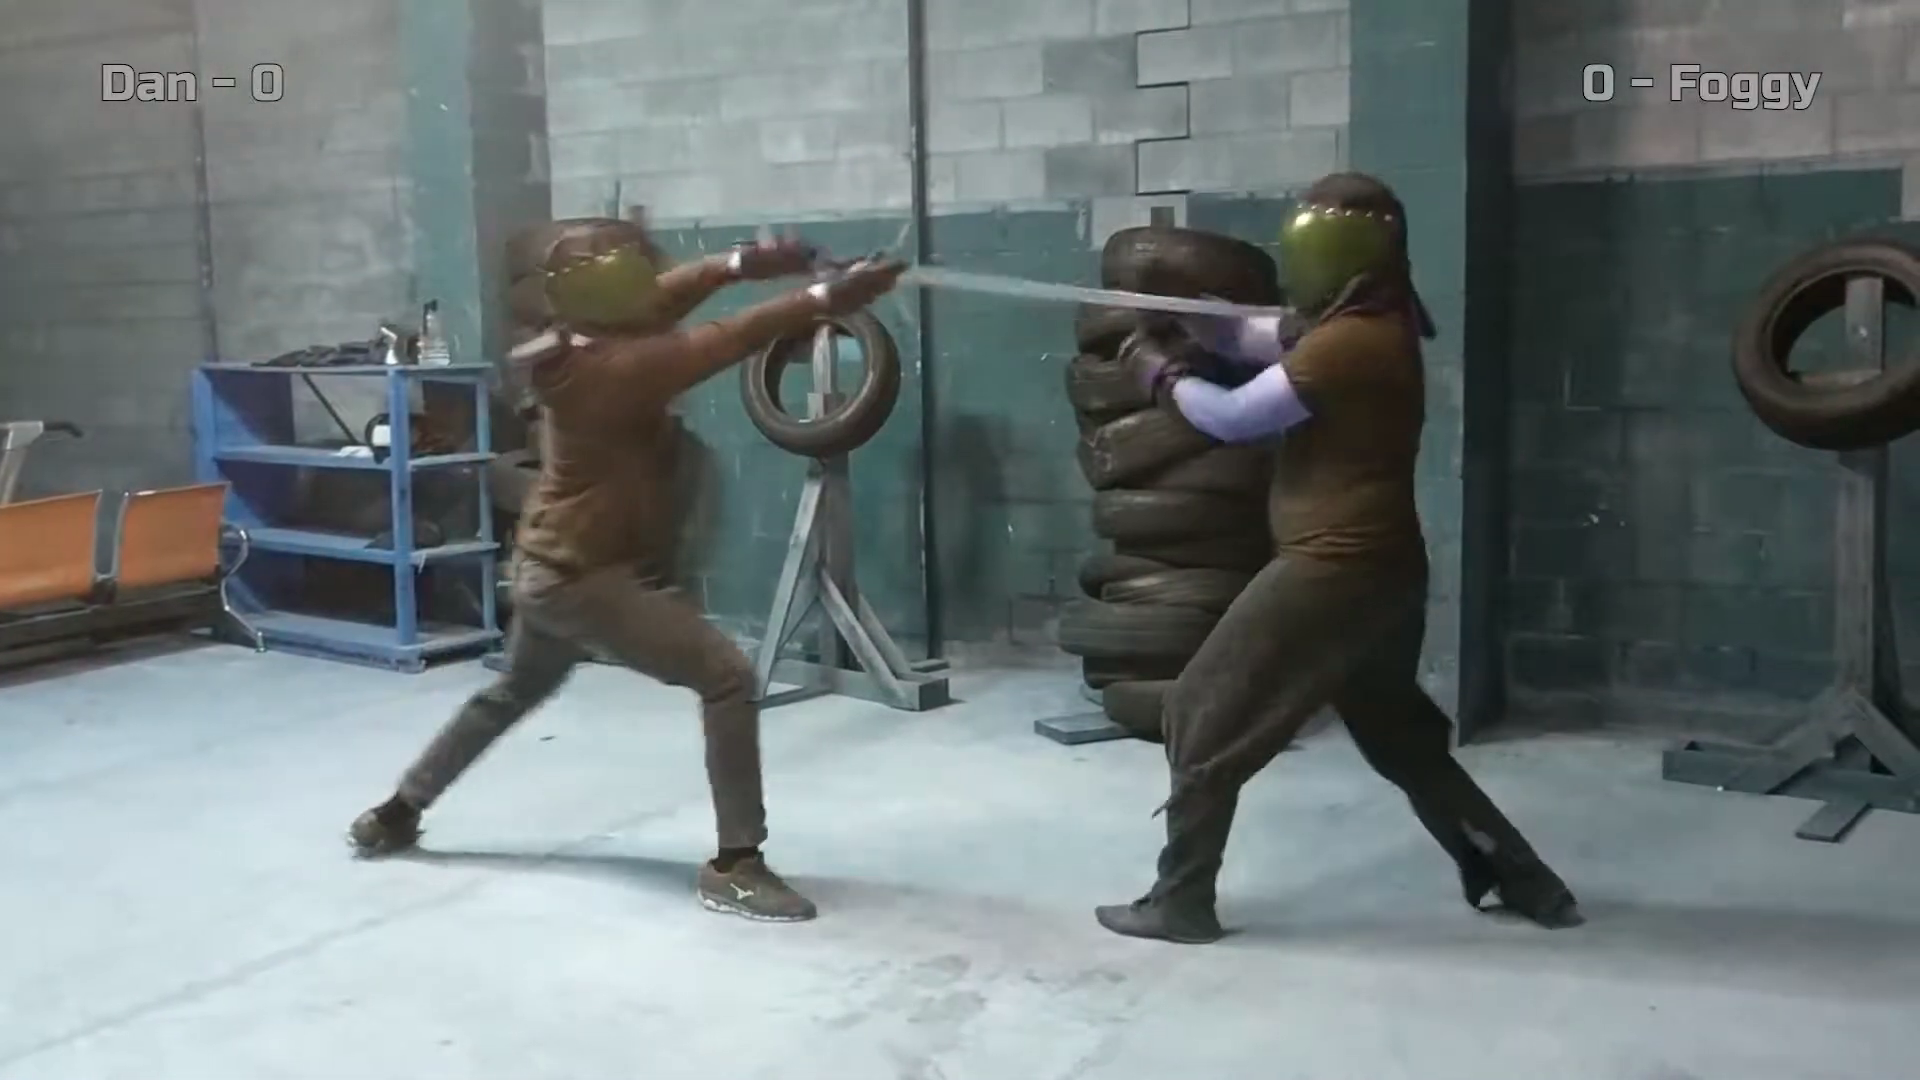

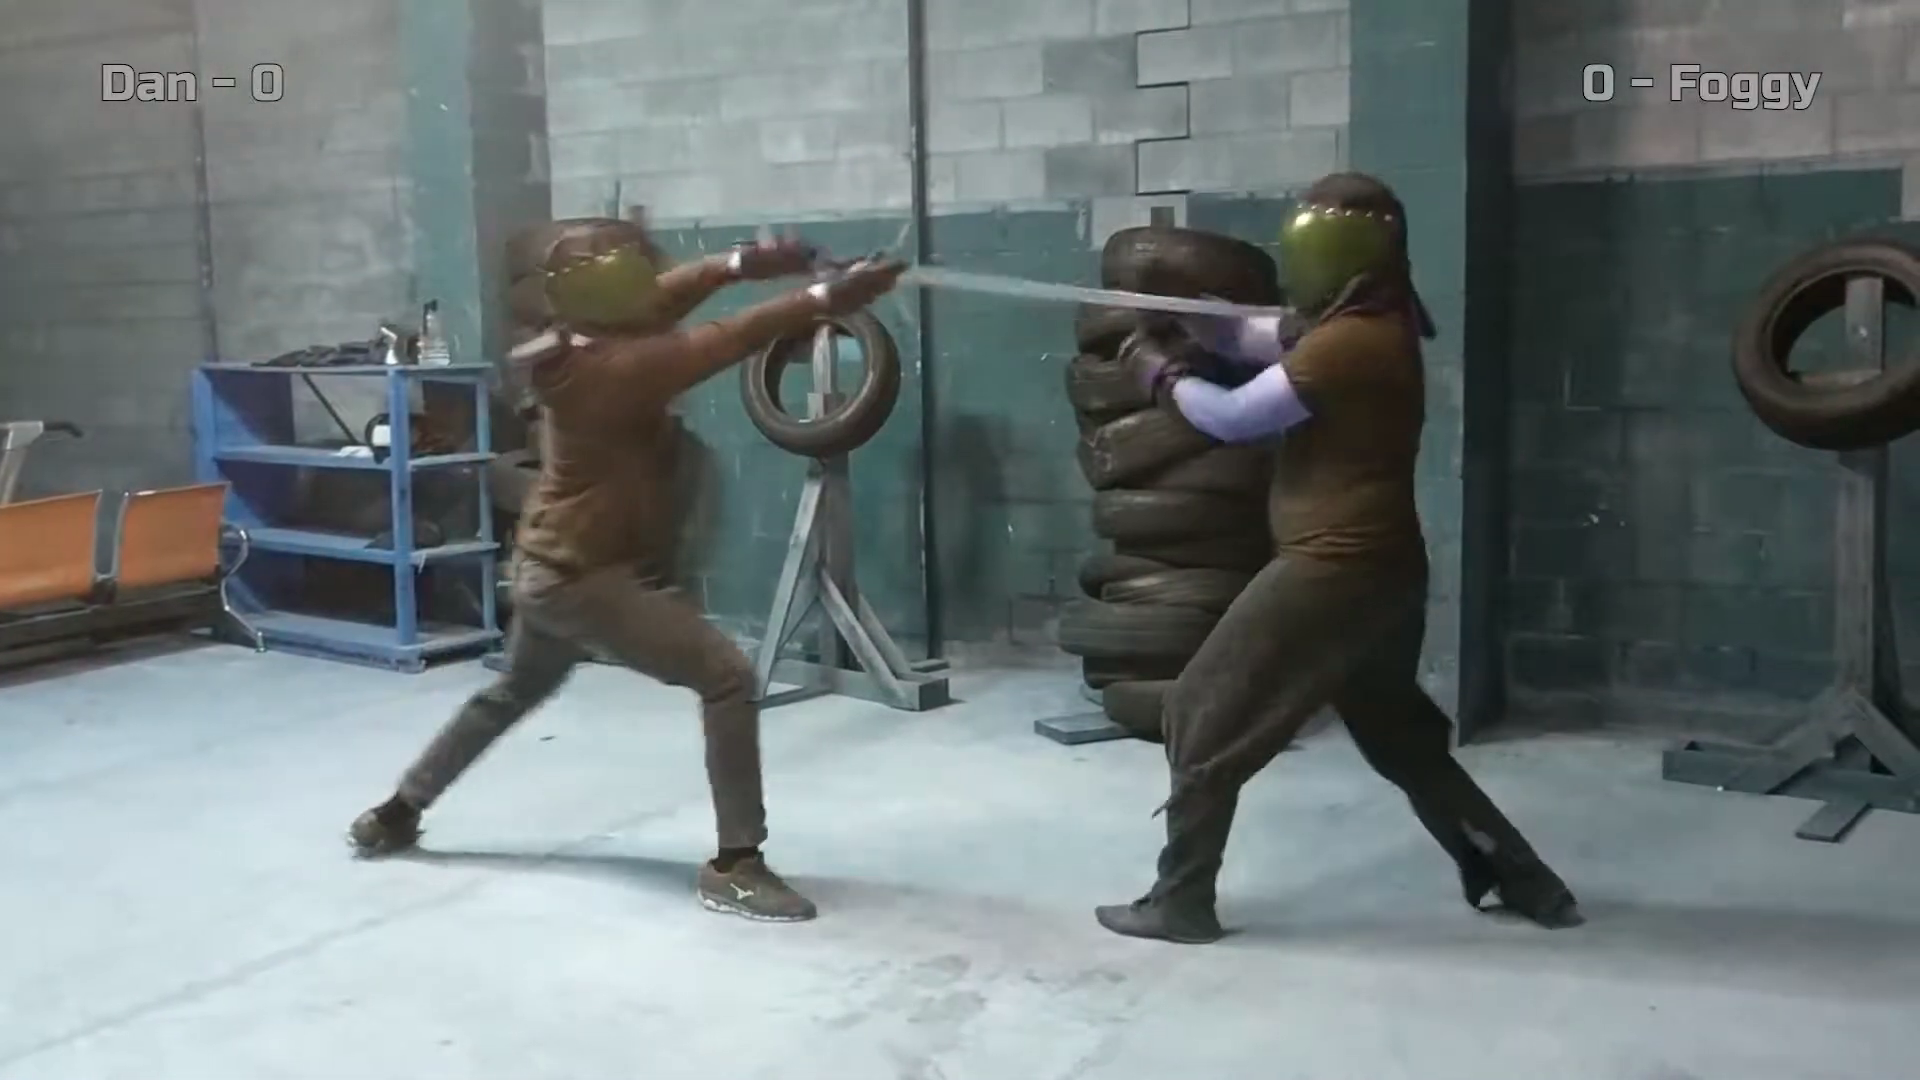

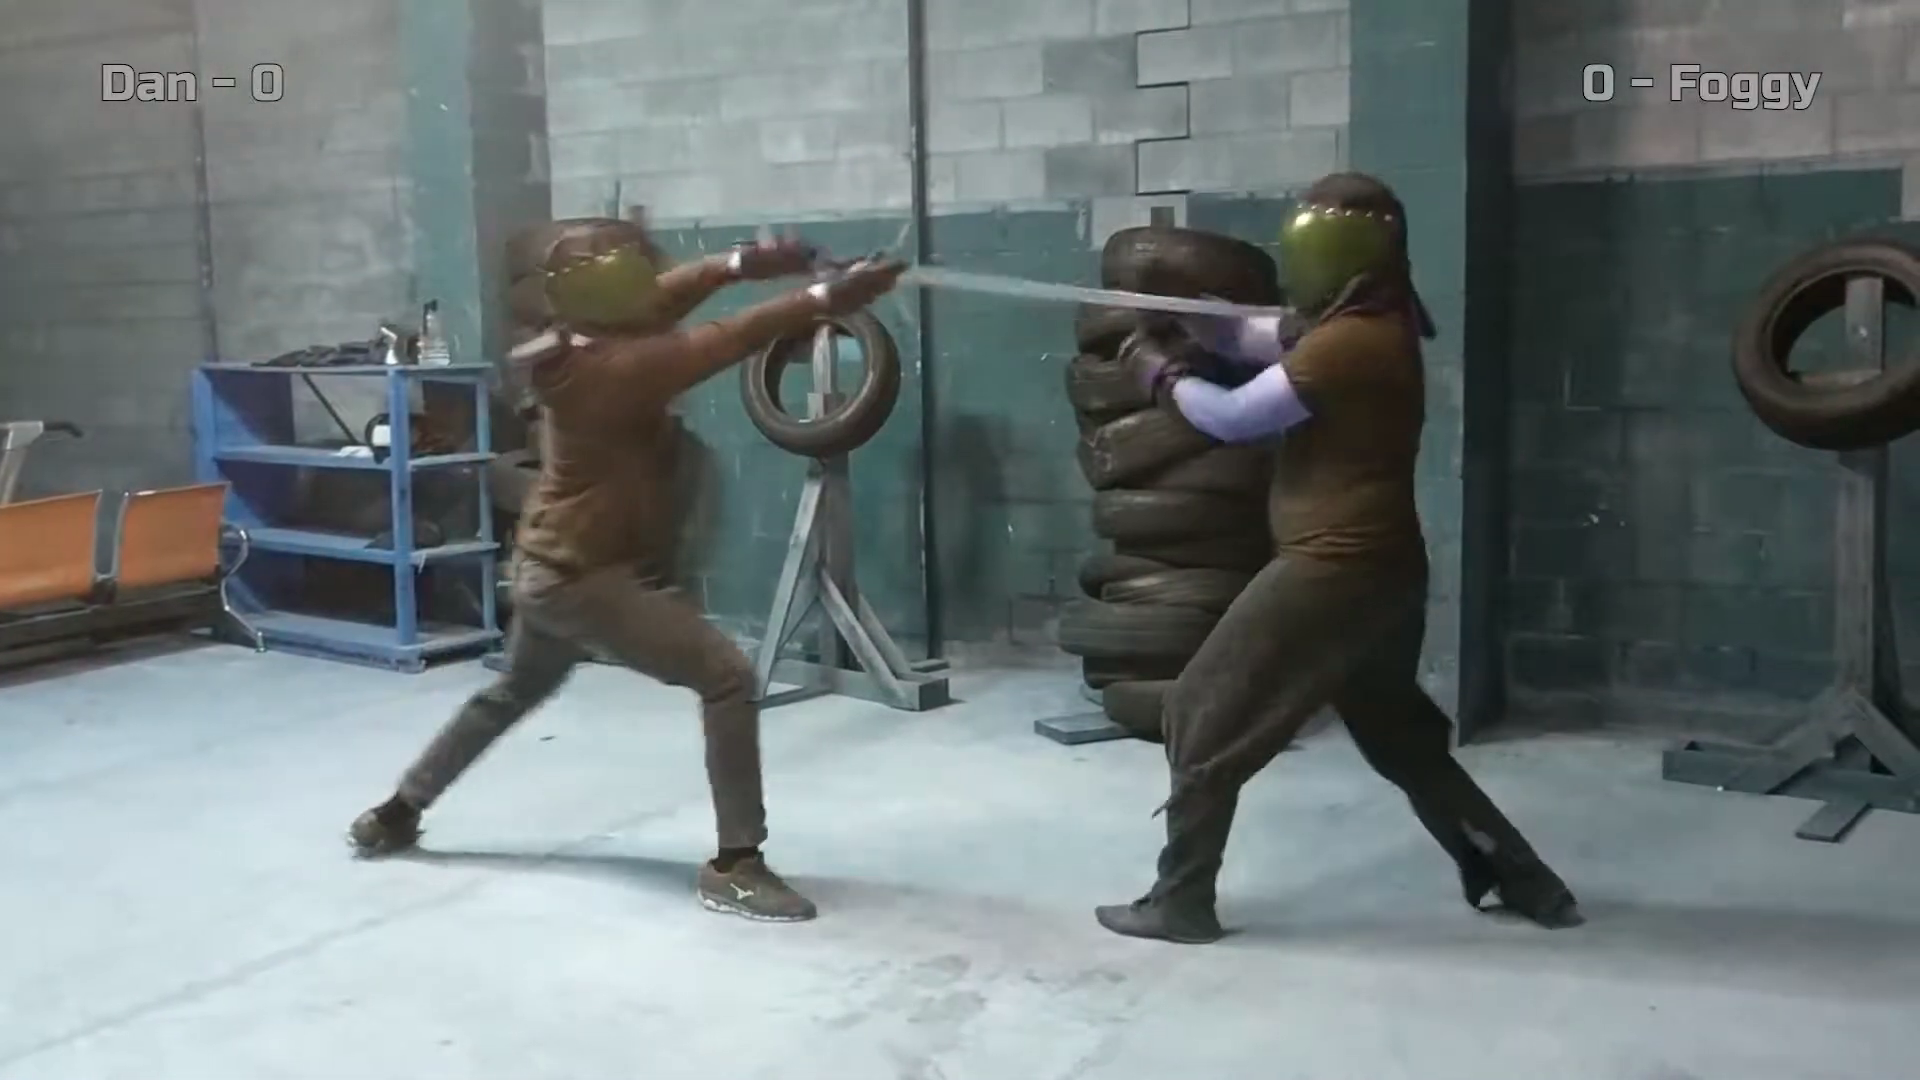

True

In [ ]:
# Load the image file from the uploaded files (get the filename)
image_path = "../images/test.png"

# Predict on the uploaded image
predictions = model.predict(image_path, confidence=40, overlap=30)  # Predict with Roboflow model
predictions.save("output.png")

# Predict on the uploaded image and store the results in predictions_json
predictions_json = model.predict(image_path).json()  # Predict with Roboflow model

# Load the image using OpenCV (this is the original input image)
image = cv2.imread(image_path)  # Read the image from path
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR (OpenCV default) to RGB for displaying

# Create a copy of the original image to display predictions
image_with_boxes = image_rgb.copy()

# Extract fencer boxes and sword lines
fencer_boxes = []
sword_lines = []

# Process the predictions and draw boxes on the image
for prediction in predictions_json['predictions']:  # Use predictions_json instead of predictions
    x_min = int(prediction['x'] - prediction['width'] / 2)
    y_min = int(prediction['y'] - prediction['height'] / 2)
    x_max = int(prediction['x'] + prediction['width'] / 2)
    y_max = int(prediction['y'] + prediction['height'] / 2)

    if prediction['class'] == 'fencer':  # Class "fencer"
        fencer_boxes.append((x_min, y_min, x_max, y_max))
        # Draw the bounding box for fencer (blue)
        cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(image_with_boxes, "Fencer", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    elif prediction['class'] == 'longsword':  # Class "longsword"
        sword_lines.append(((x_min, y_min), (x_max, y_max)))
        # Draw the sword (green)
        cv2.line(image_with_boxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Create a copy of the image_with_boxes for hit annotation
image_with_hits = image_with_boxes.copy()

# Check for hits and annotate on image_with_hits
for (x_min, y_min, x_max, y_max) in fencer_boxes:
    # Create a shapely box for the fencer
    fencer_box = box(x_min, y_min, x_max, y_max)

    for (line_start, line_end) in sword_lines:
        # Create a shapely line for the sword
        sword_line = LineString([line_start, line_end])

        # Check for intersection (hit detected)
        if fencer_box.intersects(sword_line):
            # Highlight the hit by changing sword color to red and adding "HIT!" text
            cv2.line(image_with_hits, (int(line_start[0]), int(line_start[1])),
                     (int(line_end[0]), int(line_end[1])), (0, 0, 255), 3)
            cv2.putText(image_with_hits, "HIT!", (int(x_min), int(y_min) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

# Display images using OpenCV in Colab
# Input image (original)
cv2_imshow(image_rgb)
cv2.waitKey(0)  # Wait for a key press to close the image window
cv2.destroyAllWindows()

# Prediction image (with boxes from Roboflow)
cv2_imshow(image_with_boxes)
cv2.waitKey(0)  # Wait for a key press to close the image window
cv2.destroyAllWindows()

# Annotated image (with hit detection)
cv2_imshow(image_with_hits)
cv2.waitKey(0)  # Wait for a key press to close the image window
cv2.destroyAllWindows()

# Save the annotated image with hit detection
cv2.imwrite("/content/annotated_image_with_hit.jpg", cv2.cvtColor(image_with_hits, cv2.COLOR_RGB2BGR))